In [312]:
from Common_functions import  *

%matplotlib inline

In [313]:
import glob,os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
import re
from tqdm import tqdm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as st
from os.path import expanduser
import cmath
from scipy import optimize
import time
import gzip
from scipy.interpolate import interp1d
import pandas as pd
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset,inset_axes,InsetPosition) 
import traceback
from lmfit import minimize, Parameters, Parameter, report_fit
import matplotlib.patches as patches
from sympy.solvers import solve
from sympy import Symbol
import sympy


%matplotlib inline
home = os.path.expanduser("~")

In [3]:

def med_med (true,fitted):
    temp = fitted - true
    return (np.median(np.abs(temp-np.median(temp))))

In [4]:
def cal_chisqr(model, fx, ferr):
    
    
    return np.sum(((fx-model)**2)/((ferr)**2))

In [928]:
def Calculate_PSPL_minus_Cauchy (t, m, e):
    
    
    
    df, baseline, event, it0, dt = prepare(t,m,e)


    A_max = df['A'][np.argmin(m[m>np.percentile(m, [0.0,100])[0]])] #np.max(df['A']) #1.0/(float(f_s_true)/(max(df['f'])-1+float(f_s_true)))
#     u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
    t0_true =  df['t'][np.argmin(m[m>np.percentile(m, [0.0,100])[0]])] #it0 #t[A.argmax()] #float(t0_theo)
    amp_ini =  df.A[it0] - np.median(df.A[baseline])
    tE_true = [0.01, 0.1, 1.0, 10.0, 100]
    
    fs_true = 0.5
    if A_max > 1:
        u0 = Symbol('u0')
        solve_u0 = (solve((2+u0**2)/(u0*sympy.sqrt(4+u0**2))-((A_max-(1-fs_true))/fs_true), u0))

        u0_true = np.array(solve_u0[0], dtype=np.float64)
    else:
        u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
        

    if u0_true <0.5 :
        A_lim = 1.34
    else:
        A_lim = 1.06

    interpol = interp1d(df['t'],df['A'], kind='cubic')
    dtt = np.abs(t[np.argmin(np.abs(interpol(df['t'])-A_lim))]-t0_true)
    tE_true_PSPL = dtt
    
    #################################
    
    temp_PSPL = [[], []]
#     for tE in tE_true:

    params2 = Parameters()
    params2.add('t0', value= t0_true, min=min(df['t']), max=max(df['t']))
    params2.add('tE', value= tE_true_PSPL, min=0.001, max=1000)
    params2.add('u0', value= u0_true, min=0, max=5)
#     params2.add('base', value= np.median(lightcurve[baseline,1]), min=max((lightcurve[baseline,1])), max=min((lightcurve[baseline,1])))
    params2.add('fs', value= fs_true, min=0, max=1)
#             params2.add('fb', value= 0.5, min=0, max=1)


    res2 = minimize(PSPL_data, params2, args=(df['t'].values, df['A'].values))

    temp_PSPL[0].append(res2.params)
    temp_PSPL[1].append(res2.chisqr)

    result2 = temp_PSPL[0][np.argmin(temp_PSPL[1])]

    PSPL_A = PSPL(result2['t0'], result2['tE'], result2['u0'], result2['fs'] , df['t'])
    
    c = 10*result2['tE']*result2['u0']
#     A_top_temp = df['A'][(df.t < result2['t0'] + c) & (df.t > result2['t0'] - c)]
#     if (len(A_top_temp)<5):
#         c = c*2
        
    
#     A_top_temp = df['A'][(df.t < result2['t0'] + c) & (df.t > result2['t0'] - c)]
    
#     while (len(A_top_temp)<10):
        
#         c = c*2
# #         A_top_temp = df['A'][(df.t < result2['t0'] + c) & (df.t > result2['t0'] - c)]



    t_top = df['t'][(df.t < result2['t0'] + c) & (df.t > result2['t0'] - c)]
    A_top = df['A'][(df.t < result2['t0'] + c) & (df.t > result2['t0'] - c)]
    model_top = PSPL_A[(df.t < result2['t0'] + c) & (df.t > result2['t0'] - c)]
    A_err_top = df['A_err'][(df.t < result2['t0'] + c) & (df.t > result2['t0'] - c)]

    chisqr_PSPL = np.sum((df['A'].values-PSPL_A)**2)

    chisqr_PSPL_err = cal_chisqr(PSPL_A, df['A'].values, df['A_err'].values)
    chisqr_PSPL_top = cal_chisqr(model_top, A_top.values, A_err_top.values)
    chisqr_PSPL_top_reduced = chisqr_PSPL_top/len(model_top)
    
    ##################################
    temp_bell = [[], []]
    for tE in tE_true:
        params = Parameters()
        params.add('t0', value= result2['t0'], min=result2['t0']-100, max=result2['t0']+100)
        params.add('tE', value= tE, min=0.0001, max=1000)
        params.add('b', value= 1, min=0, max=20)
        params.add('amp', value= A_max, min=0, max=1000)


        res1 = minimize(bell_curve_data, params, args=(df['t'].values, df.A ))
        temp_bell[0].append(res1.params)
        temp_bell[1].append(res1.chisqr)

    result1 = temp_bell[0][np.argmin(temp_bell[1])]
    bellcurve_A = bell_curve(df.t, result1['t0'], result1['tE'] ,result1['b'], result1['amp'])




    A_top = df['A'][(df.t < result2['t0'] + c) & (df.t > result2['t0'] - c)]
    model_top = bellcurve_A[(df.t < result2['t0'] + c) & (df.t > result2['t0'] - c)]
    A_err_top = df['A_err'][(df.t < result2['t0'] + c) & (df.t > result2['t0'] - c)]

    chisqr_bell = np.sum((df['A'].values-bellcurve_A)**2)
    chisqr_bell_err = cal_chisqr(bellcurve_A, df['A'].values, df['A_err'].values)
    chisqr_bell_top = cal_chisqr(model_top, A_top.values, A_err_top.values)
    chisqr_bell_top_reduced = chisqr_bell_top/(len(model_top))


    
    #################################
    
    topright_len = len(A_top[t_top>result2['t0']])
    topleft_len = len(A_top[t_top<result2['t0']])
    
    return df, baseline, event, topright_len, topleft_len, result1, result2, chisqr_bell, chisqr_bell_err, chisqr_PSPL,\
            chisqr_PSPL_err, chisqr_bell_top, chisqr_PSPL_top, chisqr_bell_top_reduced, chisqr_PSPL_top_reduced
    

In [929]:
# Plot for the paper = 'mag.dcnormffp_0_82_427.det.lc.W149'
name = 'mag.dcnormffp_0_82_427.det.lc.W149'
f = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/alldclc/'+str(name)
# Testing the fit on an OGLE free-floating candidate with a large value of rho

# f = 'data/OGLE_2012_BLG_0406/phot.dat'
t,m,e = np.loadtxt(f,unpack=True, usecols=(0,1, 2))

In [930]:
info[info.name == name]

,level_0,Unnamed: 0,Unnamed: 0.1,index,Unnamed: 0.1.1,Mp,alpha,base,dL,fs0,...,tE_eff_exp,tE_bell_PSPL_ratio,delta_t_true_PSPL,delta_t_true_bell,delta_t_PSPL_bell,top_number,legend_size,rho_u0_ratio,u0_pos,ones
340,340,340,340,427,427,0.0003,183.944,22.2948,3.355,0.33263,...,23.580341,1.059324,2.538566,3.48939,0.950824,3806.0,10,0.02353,0.643089,1.0


In [931]:
df, baseline, event, topright_len, topleft_len,result1, result2, chisqr_bell, chisqr_bell_err,\
chisqr_PSPL, chisqr_PSPL_err, chisqr_bell_top, chisqr_PSPL_top,\
chisqr_bell_top_reduced, chisqr_PSPL_top_reduced = Calculate_PSPL_minus_Cauchy(t, m, e)

In [932]:
print chisqr_PSPL_err-chisqr_bell_err

19168.95681552081


In [933]:
print chisqr_PSPL_top_reduced - chisqr_bell_top_reduced

1.519366500002346


In [934]:
result1

name,value,standard error,relative error,initial value,min,max,vary
t0,2459641.97,0.02506296,0.00%,,2459541.02,2459741.02,True
tE,22.8556323,0.03143774,0.14%,10.0,1.0000e-04,1000.00000,True
b,2.04901561,0.00826148,0.40%,1,0.00000000,20.0000000,True
amp,0.25653970,2.5094e-04,0.10%,1.2738913832384389,0.00000000,1000.00000,True


In [935]:
result2

name,value,standard error,relative error,initial value,min,max,vary
t0,2459641.02,0.03048631,0.00%,2459645.495451,2458346.51,2460059.24,True
tE,21.5756524,0.75276749,3.49%,26.96246899990365,1.0000e-03,1000.00000,True
u0,1.09291672,0.05685009,5.20%,0.7876050737812715,0.00000000,5.00000000,True
fs,1.00000000,0.00141844,0.14%,0.5,0.00000000,1.00000000,True


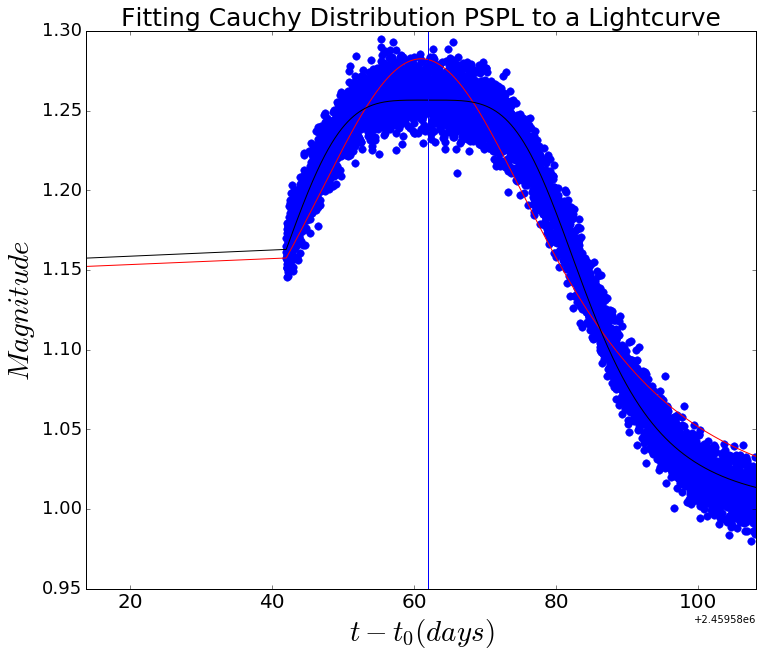

In [938]:
dtt = 2*result2['tE']*result2['u0']

PSPL_A = PSPL(result2['t0'],result2['tE'],result2['u0'],
              result2['fs'], df['t'])
bellcurve_A = bell_curve(df['t'], result1['t0'].value, 
                                  result1['tE'].value, 
                                  result1['b'].value,
                                  result1['amp'].value)
plt.figure()
plt.title('Fitting Cauchy Distribution PSPL to a Lightcurve', size=25)
plt.xlabel('$t - t_0 (days)$',size=29)
plt.ylabel('$Magnitude$',size=29)
plt.tick_params(axis='y',labelsize=18)
plt.tick_params(axis='x',labelsize=20)
plt.plot(df['t'], df['A'], 'b.', markersize=15)
#print param['t_eff=5']
plt.plot(df['t'], PSPL_A, 'r-')
plt.plot(df['t'], bellcurve_A, 'k-')
plt.axvline(result1['t0'].value)


plt.xlim(result2['t0'].value-dtt, result2['t0'].value+dtt)
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)
#fig.savefig('Trapezoid_FFP.png')

In [687]:
delta_chisqr_bell_err = chisqr_PSPL_err-chisqr_bell_err
delta_chisqr_top_reduced =  chisqr_PSPL_top_reduced - chisqr_bell_top_reduced

In [136]:
info.loc[info.name == name, 't0_bell'] = result1['t0'].value  
info.loc[info.name == name, 'tE_bell'] = result1['tE'].value  
info.loc[info.name == name, 'chisqr_bell'] = chisqr_bell  
info.loc[info.name == name, 'chisqr_bell_err'] = chisqr_bell_err  
info.loc[info.name == name, 'chisqr_bell_top'] = chisqr_bell_top  
info.loc[info.name == name, 'chisqr_bell_top_reduced'] = chisqr_bell_top_reduced  
info.loc[info.name == name, 'delta_chisqr_top_reduced'] = delta_chisqr_top_reduced  
info.loc[info.name == name, 'b_bell'] = result1['b'].value  
info.loc[info.name == name, 'amp_bell'] = result1['amp'].value  

In [241]:
info = info.drop(1090)

In [182]:
# Path to the larger dataset
home = os.path.expanduser("~")

temp = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/alldclc/'#lc/'
direc = os.listdir(temp)

In [7]:
#Fitting Cauchy to PSPL Data Challenge light curves


direc.sort()
result = {'name':[], 't0_bell':[], 'tE_bell':[], 'b_bell':[],'amp_bell':[],
          'chisqr_bell':[],'chisqr_bell_err':[], 'chisqr_bell_top':[],'chisqr_bell_top_reduced':[], 't0_PSPL':[], 'tE_PSPL':[],
          'u0_PSPL':[],'fs_PSPL':[], 'chisqr_PSPL':[],'chisqr_PSPL_err':[],'chisqr_PSPL_top': [], 'chisqr_PSPL_top_reduced': [],
          'xdata': [], 'ydata': [], 'yerr': [], 'event': [], 'topright_len': [], 'topleft_len':[]}
c = 0 

for f in tqdm(direc):
#     print f
    
    if  f.endswith('.W149') and f.split('ag')[1].startswith('.dcnormffp'):
        
        
#         print c
        c = c +1
        
        try:
            t,m,e = np.loadtxt(temp+str(f),unpack=True, usecols=(0,1, 2))


            

            df, baseline, event, topright_len, topleft_len, result1, result2, chisqr_bell, chisqr_bell_err, chisqr_PSPL, \
            chisqr_PSPL_err, chisqr_bell_top, chisqr_PSPL_top, chisqr_bell_top_reduced, chisqr_PSPL_top_reduced  = Calculate_PSPL_minus_Cauchy(t, m, e)
           
        
            result['name'].append(f)
            result['t0_bell'].append(result1['t0'].value)
            result['tE_bell'].append(result1['tE'].value)
            result['b_bell'].append(result1['b'].value)
            result['amp_bell'].append(result1['amp'].value)
            result['chisqr_bell'].append(chisqr_bell)
            result['chisqr_bell_err'].append(chisqr_bell_err)
            result['chisqr_bell_top'].append(chisqr_bell_top)
            result['chisqr_bell_top_reduced'].append(chisqr_bell_top_reduced)
            result['t0_PSPL'].append(result2['t0'].value)
            result['tE_PSPL'].append(result2['tE'].value)
            result['u0_PSPL'].append(result2['u0'].value)
            result['fs_PSPL'].append(result2['fs'].value)
#             result['base_PSPL'].append(result2['base'].value)
            result['chisqr_PSPL'].append(chisqr_PSPL)
            result['chisqr_PSPL_err'].append(chisqr_PSPL_err)
            result['chisqr_PSPL_top'].append(chisqr_PSPL_top)
            result['chisqr_PSPL_top_reduced'].append(chisqr_PSPL_top_reduced)
            result['xdata'].append(t)
            result['ydata'].append(m)
            result['yerr'].append(e)
            result['topright_len'].append(topright_len)
            result['topleft_len'].append(topleft_len)
            
            
        except (RuntimeError, TypeError, NameError, ValueError):
            traceback.print_exc()
            print f
            pass
#     if c == 4:
#         break

print 'done'










  0%|          | 0/9948 [00:00<?, ?it/s]/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in double_scalars
/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 9948/9948 [1:24:11<00:00,  1.97it/s]  

done


In [9]:
# info1 = pd.read_csv('answer_keys/ombin.CSV')
# info2 = pd.read_csv('answer_keys/omcassan.CSV')
# info3 = pd.read_csv('answer_keys/dccv.CSV')
info = pd.read_csv('answer_keys/dcnormffp.CSV')

In [528]:
frames = [info1, info2, info3, info4]

info = pd.concat(frames)

/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [529]:
# info = info.rename(columns={"index": "name"})

In [889]:
# info = info.reset_index()

ValueError: cannot insert level_0, already exists

In [10]:
for i in range(len(result['name'])):

    if result['name'][i].split('.lc')[0].endswith('all'): 
        result['name'][i] = result['name'][i].split('all')[0]+'det'+result['name'][i].split('all')[1]

In [11]:

c = 0
x = info.name
y = result['name']
for j in range(len(x)):
    
    if not x[j] in y:
        info = info.drop([j])
        c = c + 1
print c
        



358


In [13]:
# info = info.drop(['level_0', 'index'], axis=1)

In [336]:
info = info.reset_index()

In [560]:
info['type'] = np.zeros(len(info))

for i in tqdm(range(len(info))):
    
    if info['name'][i].split('mag')[1].startswith('.ombin'):
        
        info.set_value(i, 'type', 1)
        
    if info['name'][i].split('mag')[1].startswith('.dccv'):
        
        info.set_value(i, 'type', 0)
        
    if info['name'][i].split('mag')[1].startswith('.dcnormffp'):
        
        info.set_value(i, 'type', 3)
        
    if info['name'][i].split('mag')[1].startswith('.omcassan'):
        
        info.set_value(i, 'type', 2)

100%|██████████| 5578/5578 [00:00<00:00, 12794.69it/s]


In [15]:
info['t0_bell'] = np.zeros(len(info))
info['tE_bell'] = np.zeros(len(info))
info['chisqr_bell'] = np.zeros(len(info))
info['chisqr_bell_err'] = np.zeros(len(info))
info['chisqr_bell_top'] = np.zeros(len(info))
info['chisqr_bell_top_reduced'] = np.zeros(len(info))
info['b_bell'] = np.zeros(len(info))
info['amp_bell'] = np.zeros(len(info))
info['t0_PSPL'] = np.zeros(len(info))
info['tE_PSPL'] = np.zeros(len(info))
info['u0_PSPL'] = np.zeros(len(info))
info['fs_PSPL'] = np.zeros(len(info))
# info['fb_PSPL'] = np.zeros(len(info))
info['base_PSPL'] = np.zeros(len(info))
info['chisqr_PSPL'] = np.zeros(len(info))
info['chisqr_PSPL_err'] = np.zeros(len(info))
info['chisqr_PSPL_top'] = np.zeros(len(info))
info['chisqr_PSPL_top_reduced'] = np.zeros(len(info))
info['topright_len'] = np.zeros(len(info))
info['topleft_len'] = np.zeros(len(info))




for i in range(len(result['name'])):
    #print i
    
    info.loc[info.name == result['name'][i],'t0_bell'] = result['t0_bell'][i]-2458234
    info.loc[info.name == result['name'][i],'tE_bell'] = result['tE_bell'][i]
    info.loc[info.name == result['name'][i],'b_bell'] = result['b_bell'][i]
    info.loc[info.name == result['name'][i],'amp_bell'] = result['amp_bell'][i]
    info.loc[info.name == result['name'][i], 't0_PSPL'] = result['t0_PSPL'][i]-2458234
    info.loc[info.name == result['name'][i], 'tE_PSPL'] = result['tE_PSPL'][i]
    info.loc[info.name == result['name'][i], 'u0_PSPL'] = result['u0_PSPL'][i]
    info.loc[info.name == result['name'][i], 'fs_PSPL'] = result['fs_PSPL'][i]
#     info.loc[info.name == result['name'][i], 'fb_PSPL'] = result['fb_PSPL'][i].value
    info.loc[info.name == result['name'][i], 'chisqr_bell'] = result['chisqr_bell'][i]
    info.loc[info.name == result['name'][i], 'chisqr_PSPL'] = result['chisqr_PSPL'][i]
    info.loc[info.name == result['name'][i], 'chisqr_PSPL_err'] = result['chisqr_PSPL_err'][i]
    info.loc[info.name == result['name'][i], 'chisqr_PSPL_top'] = result['chisqr_PSPL_top'][i]
    info.loc[info.name == result['name'][i], 'chisqr_PSPL_top_reduced'] = result['chisqr_PSPL_top_reduced'][i]
    info.loc[info.name == result['name'][i], 'chisqr_bell_err'] = result['chisqr_bell_err'][i]
    info.loc[info.name == result['name'][i], 'chisqr_bell_top'] = result['chisqr_bell_top'][i]
    info.loc[info.name == result['name'][i], 'chisqr_bell_top_reduced'] = result['chisqr_bell_top_reduced'][i]
    info.loc[info.name == result['name'][i], 'topright_len'] = result['topright_len'][i]
    info.loc[info.name == result['name'][i], 'topleft_len'] = result['topleft_len'][i]



    

print 'done'

done


In [16]:
info['delta_chisqr_err'] = info.chisqr_PSPL_err - info.chisqr_bell_err
info['delta_chisqr_top'] = info.chisqr_PSPL_top - info.chisqr_bell_top
info['delta_chisqr'] = info.chisqr_PSPL - info.chisqr_bell
info['delta_chisqr_top_reduced'] = info.chisqr_PSPL_top_reduced - info.chisqr_bell_top_reduced
info['tE_eff'] = info.tE * info.u0
info['tE_eff_exp'] = info.tE_PSPL * info.u0_PSPL
info['tE_bell_PSPL_ratio'] = np.abs(info.tE_bell/info.tE_PSPL)
info['delta_t_true_PSPL'] = np.abs(info.t0-info.t0_PSPL)
info['delta_t_true_bell'] = np.abs(info.t0-info.t0_bell)
info['delta_t_PSPL_bell'] = np.abs(info.t0_PSPL-info.t0_bell)

In [538]:
info['top_number'] = info.topright_len + info.topleft_len

In [662]:
info['rho_u0_ratio'] = np.abs(info.rho/info.u0)

In [545]:
legend_size = []

for i in info.top_number:
    
    if i <2 :
        legend_size.append(1)
    else:
        legend_size.append(10)

In [546]:
info['legend_size'] = legend_size

In [910]:
# info.to_csv('test_result/Cauchy/Cauchy_PSPL_results_V3.CSV')

In [315]:
# info = pd.read_csv('test_result/Cauchy/Cauchy_PSPL_results_V3.CSV')

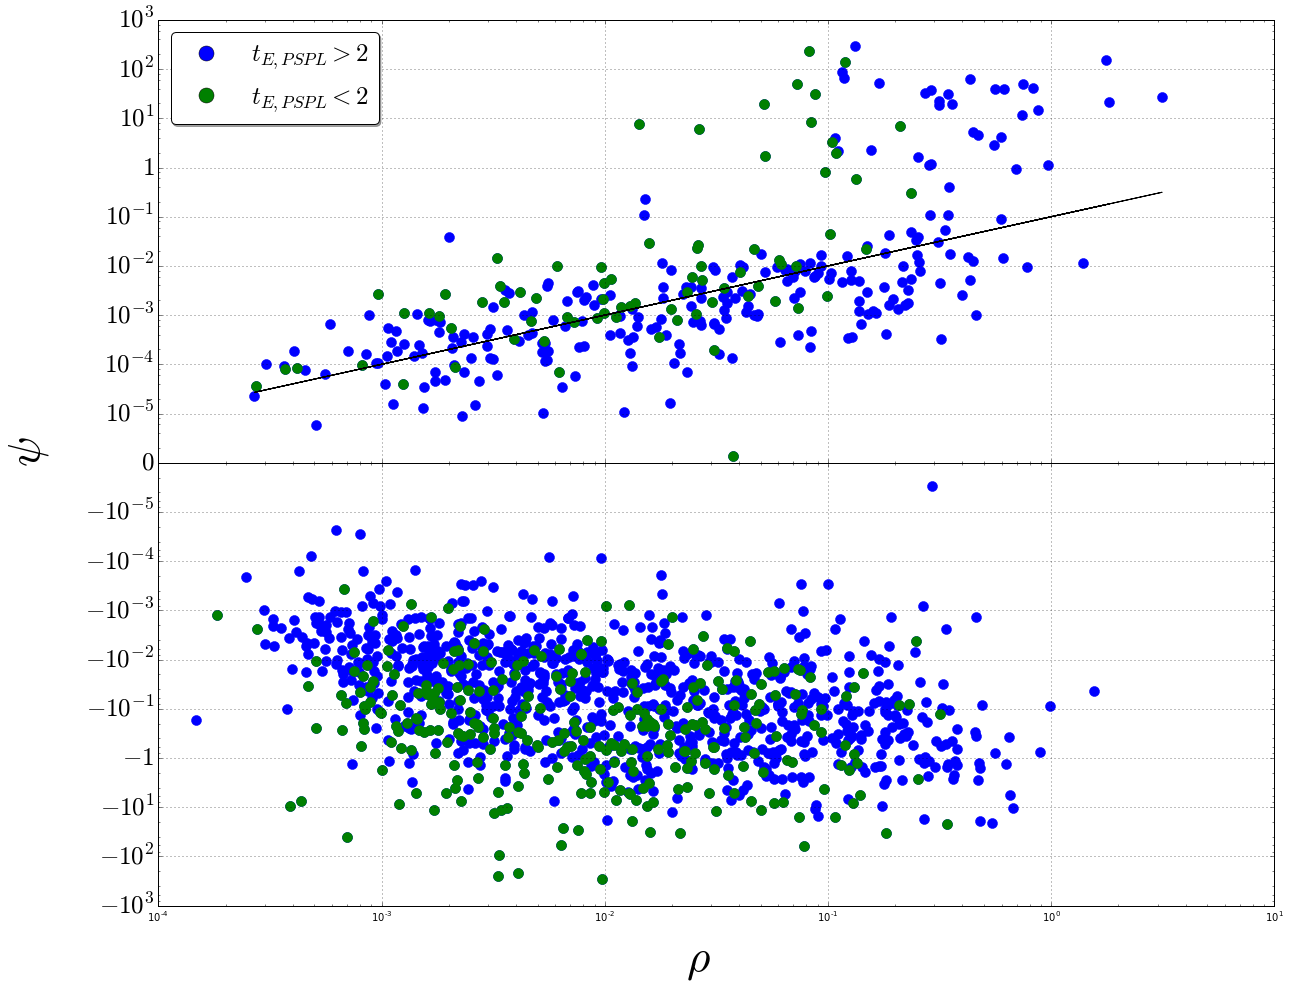

In [676]:
x = 'rho'
y = 'delta_chisqr_top_reduced'
z_lim = 1
z = 'b_bell'
c = info[z]
legend_elements = []
g = 'u0'
num_cut = 2


fig, axs = plt.subplots(2, 1, sharex=True)


axs[0].plot(np.abs(info[x][(info.delta_chisqr_top_reduced>0) & (info.top_number> num_cut)]), 
         np.abs(info[y][ (info.delta_chisqr_top_reduced>0) & (info.top_number> num_cut)]), 'b.', markersize = 20, 
            label='$All$')
axs[0].plot(np.abs(info[x][(info[z]<z_lim)& (info.delta_chisqr_top_reduced>0)& (info.top_number> num_cut)]), 
         np.abs(info[y][ (info[z]<z_lim)& (info.delta_chisqr_top_reduced>0)& (info.top_number> num_cut)]), 
            'g.', markersize = 20, label = '${t_E}_{fitted} < 2$')
axs[0].plot(np.abs(info[x][(info.delta_chisqr_top_reduced>0)& (info.top_number> num_cut)]), 
         np.abs(info[x][(info.delta_chisqr_top_reduced>0)& (info.top_number> num_cut)]), 
            'k-')
# axs[0].plot(np.abs(info[x][(info.delta_chisqr_top_reduced>0) & ( (info.topright_len <1) | (info.topleft_len <1) )]), 
#          np.abs(info[y][(info.delta_chisqr_top_reduced>0) & ( (info.topright_len <1) | (info.topleft_len <1) )]), 
#             'r.', markersize = 20)
legend_elements.append(Line2D([0], [0], marker='o', color='w', label='$t_{E,PSPL} > 2$',
                          markerfacecolor='b', markersize=15))
legend_elements.append(Line2D([0], [0], marker='o', color='w', label='$t_{E,PSPL} < 2$',
                          markerfacecolor='g', markersize=15))


axs[0].set_xscale('log')
axs[0].set_yscale('log')
# axs[0].set_xticklabels(['', '','${10}^{-3}$','${10}^{-2}$','${10}^{-1}$',
#                         '${10}^0$', '${10}^1$', '${10}^2$', ''],
#                           rotation = 0, fontsize =25)
# axs[0].tick_params(axis='y',which='both', left = True)


axs[0].set_yticklabels(['', '','${10}^{-5}$','${10}^{-4}$',
                        '${10}^{-3}$', '${10}^{-2}$', '${10}^{-1}$', 
                        '$1$','${10}^{1}$','${10}^{2}$','${10}^{3}$', ''], rotation = 0, fontsize =25)
# # axs[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1,1e0,1e1,1e2, 1e3])
axs[0].grid()
# axs[0].legend(bbox_to_anchor=(1.02, 0., 1.03, 1.),handles=legend_elements, loc='right',
#            ncol=1, mode="expand", borderaxespad=0. ,prop={'size': 22})


# ttl = axs[1].set_title('$Events \;\; with \;\; {{\chi}^2}_{PSPL} \; - \; {{\chi}^2}_{Cauchy} < 0$', size =32)
# ttl.set_position([.5, 1.01])

axs[1].plot(np.abs(info[x][ (info.delta_chisqr_top_reduced<0) & (info.top_number> num_cut)]), 
         np.abs(info[y][ (info.delta_chisqr_top_reduced<0)& (info.top_number> num_cut) ]), 'b.', markersize = 20,
           label='$All$')
# axs[1].plot(np.abs(info[x][ (info.delta_chisqr_top_reduced<0)]), 
#          np.abs(info[x][(info.delta_chisqr_top_reduced<0)]), 'k-', markersize = 20)
axs[1].plot(np.abs(info[x][ (info[z]<z_lim)& (info.delta_chisqr_top_reduced<0)& (info.top_number> num_cut)]), 
         np.abs(info[y][ (info[z]<z_lim)& (info.delta_chisqr_top_reduced<0)& (info.top_number> num_cut)]), 
            'g.', markersize = 20, label = '${t_E}_{fitted} < 2$')
# axs[1].plot(np.abs(info[x][(info.delta_chisqr_top_reduced<0) & ( (info.topright_len <1) | (info.topleft_len <1) )]), 
#          np.abs(info[y][(info.delta_chisqr_top_reduced<0) & ( (info.topright_len <1) | (info.topleft_len <1) )]), 
#             'r.', markersize = 20)

axs[0].legend(handles=legend_elements, loc='upper left', ncol=1,numpoints=1, shadow=True, fancybox=True, prop={'size': 25})

axs[1].set_xscale('log')
axs[1].set_yscale('log')
# axs[1].set_ylim(0.01,10)
axs[1].invert_yaxis()
# axs[1].set_xticklabels(['','${10}^{-4}$', '${10}^{-3}$','${10}^{-2}$','${10}^{-1}$',
#                         '$1$','$10$'],
#                           rotation = 0, fontsize =25)
axs[1].set_yticklabels(['', '$0$','$-{10}^{-5}$','$-{10}^{-4}$','$-{10}^{-3}$',
                        '$-{10}^{-2}$', '$-{10}^{-1}$', '$-1$', 
                        '$-{10}^{1}$','$-{10}^{2}$','$-{10}^{3}$','$-{10}^{4}$','$-{10}^{5}$'], rotation = 0, fontsize =25)
# axs[1].set_xlim(1e-4, 5)
axs[1].grid()

# print float(len(info[x][(info.type==3)  & (info['rho']>0.01)& (info.delta_chisqr<0)]))/ float(len(info[x][(info.type==3) & (info.delta_chisqr<0) ]))
# print float(len(info[x][(info.type==3)  & (info[z]<z_lim)& (info.delta_chisqr<0)]))/ float(len(info[x][(info.type==3) & (info.delta_chisqr<0) ]))


plt.subplots_adjust(left=None, bottom=0.08, right=None, top=None,
                    wspace=0.0, hspace=0.0) 
fig.text(0.5, 0.02, r'$\rho$', ha='center',size=45)
fig.text(0.02, 0.5, '$\psi$', va='center', rotation='vertical',size=45)
fig = plt.gcf()
fig.set_size_inches(20.0,15.0)
# fig.savefig('Cauchy_delta_chi_rho_V3.png')

In [50]:
med_med(np.log10(np.abs(info[x][ (info.delta_chisqr_top_reduced>0)])), 
         np.log10(np.abs(info[y][(info.delta_chisqr_top_reduced>0) ])))

0.5976047454581246

In [51]:
med_med(np.log10(np.abs(info[x][(info.delta_chisqr_top_reduced<0) ])), 
         np.log10(np.abs(info[y][(info.delta_chisqr_top_reduced<0)])))

0.7607652634609032

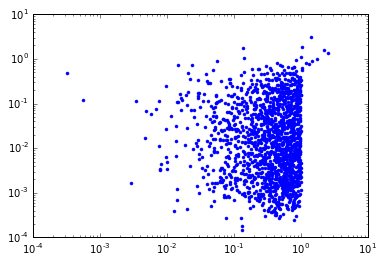

In [637]:
plt.plot(np.abs(info.u0), np.abs(info.rho), 'b.')
# plt.plot(np.abs(info.tE_PSPL), np.abs(info.tE_PSPL), 'k-')


plt.xscale('log')
plt.yscale('log')

In [911]:
# info[['name','u0','u0_PSPL', 't0', 't0_PSPL', 't0_bell', 'delta_chisqr_top_reduced','delta_chisqr_err', 'tE','tE_bell','tE_PSPL','tE_eff_exp','b_bell','rho', 'topright_len', 'topleft_len', 'rho_u0_ratio']][(info.rho_u0_ratio>1) & (info[y]>0) & (info.top_number> num_cut) ]

In [736]:
info['ones'] = np.ones(len(info.name))

In [665]:
info['u0_pos'] = np.abs(info.u0)

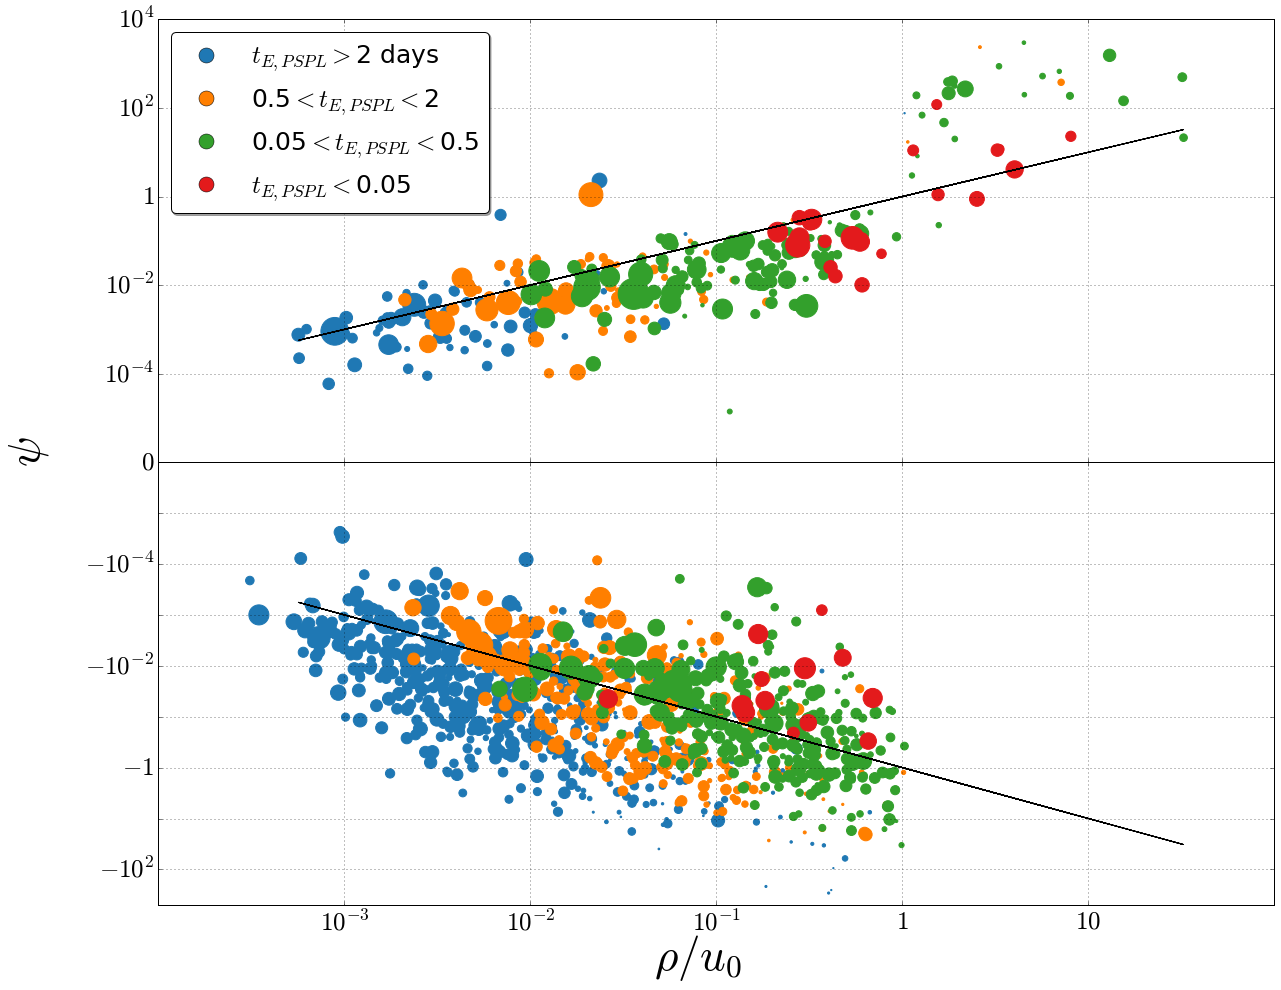

In [915]:
x = 'rho_u0_ratio'
y = 'delta_chisqr_top_reduced'
z_lim1 = 0.05
z_lim2 = 0.5
z_lim3 = 2
z = 'tE_PSPL'
w = 'u0_PSPL'
w_c = 200
legend_element = []
num_cut = 3

fig, axs = plt.subplots(2, 1, sharex=True)

c00 = (info[w][(info[z]>z_lim3)& (info.delta_chisqr_top_reduced>0) & (info.top_number> num_cut)])
c01 = info[w][(info[z]>z_lim2)&(info[z]<z_lim3)& (info.delta_chisqr_top_reduced>0) & (info.top_number> num_cut)]
c02 = info[w][(info[z]>z_lim1)&(info[z]<z_lim2)& (info.delta_chisqr_top_reduced>0) & (info.top_number> num_cut)]
c03 = info[w][(info[z]<z_lim1)& (info.delta_chisqr_top_reduced>0) & (info.top_number> num_cut)]


axs[0].scatter(np.log10(np.abs(info[x][(info[z]>z_lim3)& (info.delta_chisqr_top_reduced>0) & (info.top_number> num_cut)])), 
         np.log10(np.abs(info[y][(info[z]>z_lim3)&  (info.delta_chisqr_top_reduced>0)& (info.top_number> num_cut) ])), s=w_c*c00, c='#1f78b4', edgecolor = '#1f78b4')
axs[0].scatter(np.log10(np.abs(info[x][(info[z]>z_lim2)&(info[z]<z_lim3)& (info.delta_chisqr_top_reduced>0) & (info.top_number> num_cut)])), 
         np.log10(np.abs(info[y][ (info[z]>z_lim2)&(info[z]<z_lim3)& (info.delta_chisqr_top_reduced>0) & (info.top_number> num_cut)])), s=w_c*c01, c='#ff7f00', edgecolor ='#ff7f00')
axs[0].scatter(np.log10(np.abs(info[x][(info[z]>z_lim1)&(info[z]<z_lim2)& (info.delta_chisqr_top_reduced>0)& (info.top_number> num_cut) ])), 
         np.log10(np.abs(info[y][ (info[z]>z_lim1)&(info[z]<z_lim2)& (info.delta_chisqr_top_reduced>0)& (info.top_number> num_cut) ])), s=w_c*c02, c='#33a02c', edgecolor ='#33a02c')
axs[0].scatter(np.log10(np.abs(info[x][(info[z]<z_lim1)& (info.delta_chisqr_top_reduced>0) & (info.top_number> num_cut)])), 
         np.log10(np.abs(info[y][ (info[z]<z_lim1)& (info.delta_chisqr_top_reduced>0)& (info.top_number> num_cut) ])), s=w_c*c03, c='#e31a1c', edgecolor ='#e31a1c')



axs[0].plot(np.log10(np.abs(info[x][(info.delta_chisqr_top_reduced>0)& (info.top_number> num_cut) ])), 
            np.log10(np.abs(info[x][(info.delta_chisqr_top_reduced>0)& (info.top_number> num_cut) ])),'k-')


legend_element.append(Line2D([0], [0], marker='o', color='w', label='$t_{E,PSPL} > $'+ str(z_lim3)+' days',
                          markerfacecolor='#1f78b4', markersize=15))
legend_element.append(Line2D([0], [0], marker='o', color='w', label=str(z_lim2)+'$ < t_{E,PSPL} < $'+str(z_lim3),
                          markerfacecolor='#ff7f00', markersize=15))
legend_element.append(Line2D([0], [0], marker='o', color='w', label=str(z_lim1)+'$ < t_{E,PSPL} < $'+str(z_lim2),
                          markerfacecolor='#33a02c', markersize=15))
legend_element.append(Line2D([0], [0], marker='o', color='w', label='$t_{E,PSPL} < $'+str(z_lim1),
                          markerfacecolor='#e31a1c', markersize=15))
axs[0].legend(handles=legend_element, loc='upper left', ncol=1,numpoints=1, shadow=True, 
              fancybox=True, prop={'size': 25})

axs[0].set_yticklabels(['', '${10}^{-4}$','${10}^{-2}$', 
                        '$1$', '${10}^2$', '${10}^4$'], rotation = 0, fontsize =25)
axs[0].grid()
axs[0].set_ylim(-6, np.log10(10000))




c10 = info[w][(info[z]>z_lim3)& (info.delta_chisqr_top_reduced<0) & (info.top_number> num_cut)]
c11 = info[w][(info[z]>z_lim2)&(info[z]<z_lim3)& (info.delta_chisqr_top_reduced<0)& (info.top_number> num_cut) ]
c12 = info[w][(info[z]>z_lim1)&(info[z]<z_lim2)& (info.delta_chisqr_top_reduced<0)& (info.top_number> num_cut) ]
c13 = info[w][(info[z]<z_lim1)& (info.delta_chisqr_top_reduced<0) & (info.top_number> num_cut)]


axs[1].scatter(np.log10(np.abs(info[x][(info[z]>z_lim3)&(info.delta_chisqr_top_reduced<0) & (info.top_number> num_cut)])), 
            np.log10(np.abs(info[y][(info[z]>z_lim3)&(info.delta_chisqr_top_reduced<0) & (info.top_number> num_cut)])), s = w_c*c10, c = '#1f78b4', edgecolor = '#1f78b4')
axs[1].scatter(np.log10(np.abs(info[x][(info[z]>z_lim2)&(info[z]<z_lim3)&(info.delta_chisqr_top_reduced<0) & (info.top_number> num_cut)])), 
            np.log10(np.abs(info[y][(info[z]>z_lim2)&(info[z]<z_lim3)&(info.delta_chisqr_top_reduced<0)& (info.top_number> num_cut) ])), s = w_c*c11, c = '#ff7f00', edgecolor ='#ff7f00')
axs[1].scatter(np.log10(np.abs(info[x][(info[z]>z_lim1)&(info[z]<z_lim2)& (info.delta_chisqr_top_reduced<0)& (info.top_number> num_cut) ])), 
         np.log10(np.abs(info[y][ (info[z]>z_lim1)&(info[z]<z_lim2)& (info.delta_chisqr_top_reduced<0) & (info.top_number> num_cut)])), s=w_c*c12, c='#33a02c', edgecolor ='#33a02c')
axs[1].scatter(np.log10(np.abs(info[x][(info[z]<z_lim1)& (info.delta_chisqr_top_reduced<0) & (info.top_number> num_cut)])), 
         np.log10(np.abs(info[y][ (info[z]<z_lim1)& (info.delta_chisqr_top_reduced<0)& (info.top_number> num_cut) ])), s=w_c*c13, c='#e31a1c', edgecolor ='#e31a1c')

axs[1].plot(np.log10(np.abs(info[x][(info.delta_chisqr_top_reduced>0)& (info.top_number> num_cut) ])), 
            np.log10(np.abs(info[x][(info.delta_chisqr_top_reduced>0)& (info.top_number> num_cut) ])),'k-')
# legend1 = axs[0].legend(*scatter.legend_elements(),
#                     loc="lower left", title="Classes")
# axs[0].add_artist(legend1)


axs[1].invert_yaxis()
axs[1].set_xticklabels(['', '${10}^{-3}$','${10}^{-2}$','${10}^{-1}$',
                        '$1$','$10$',''], rotation = 0, fontsize =25)
axs[1].set_yticklabels(['$0$','','$-{10}^{-4}$','',
                        '$-{10}^{-2}$','','$-1$', '',
                        '$-{10}^{2}$'], rotation = 0, fontsize =25)
axs[1].set_xlim(-4, np.log10(100))
axs[1].set_ylim(np.log10(500),-6)


axs[1].grid()


# ######
# legend_sizes = np.sort(c10)[::len(c10)//4][-3:]

# # get the indices for each of the legend sizes
# indices = [np.where(c10==v)[0][0] for v in legend_sizes]

# # plot each point again, and its value as a label
# for i in indices:
#     axs[1].scatter(np.log10(np.abs(info[x][(info[z]>z_lim)&(info.delta_chisqr_top_reduced<0) ]))[i],
#                    np.log10(np.abs(info[y][(info[z]>z_lim)&(info.delta_chisqr_top_reduced<0) ]))[i],
#                    s=w_c*c10[i],c='#1f78b4',
#                    label='{:.2f}'.format(c10[i]))
# # add the legend
# axs[1].legend(scatterpoints=1)

# ######

plt.subplots_adjust(left=None, bottom=0.08, right=None, top=None,
                    wspace=0.0, hspace=0.0) 
fig.text(0.5, 0.02, r'$\rho / u_0$', ha='center',size=45)
fig.text(0.02, 0.5, '$\psi$', va='center', rotation='vertical',size=45)
fig = plt.gcf()
fig.set_size_inches(20.0,15.0)
fig.savefig('test_result/Cauchy/Cauchy_delta_chi_rho_V7.png')

In [917]:
med_med(np.log10(np.abs(info[x][(info.delta_chisqr_top_reduced<0)& (info.top_number> num_cut)])), 
         np.log10(np.abs(info[y][(info.delta_chisqr_top_reduced<0)& (info.top_number> num_cut)])))

0.6378733412449256

In [ ]:
[(np.abs(info.topleft_len-info.topright_len)>200) ]

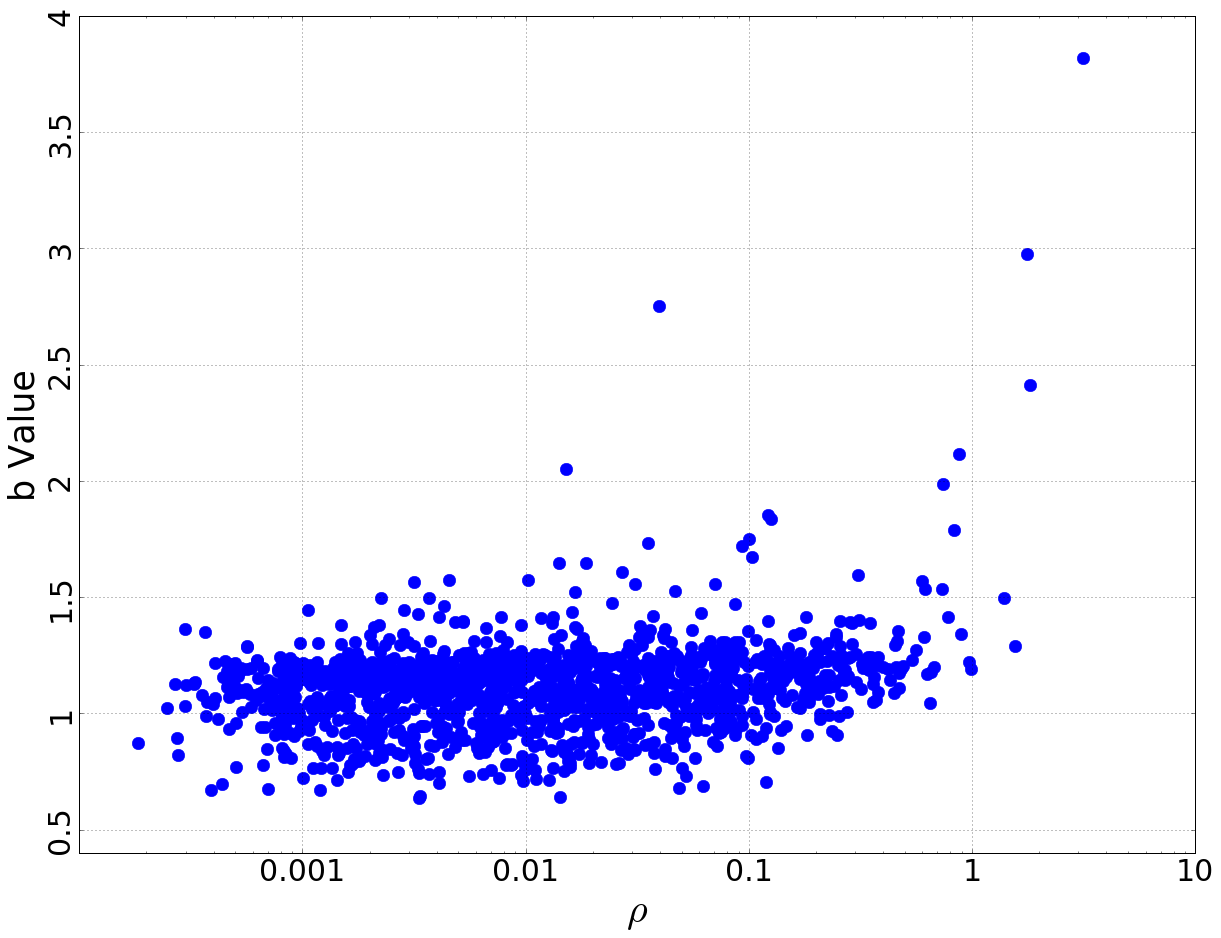

In [880]:
plt.plot(info['rho'][(info.top_number> num_cut)], 
         info['b_bell'][(info.top_number> num_cut)], 'b.', markersize=25)
# plt.plot(info.rho_u0_ratio[(info.top_number> num_cut)], 
#          np.abs(info.delta_chisqr_top_reduced[(info.top_number> num_cut)]), 'b.', markersize=25)
# plt.plot(info.rho_u0_ratio[(info.top_number> num_cut)& (info[y]>0)], 
#          np.abs(info.delta_chisqr_top_reduced[(info.top_number> num_cut)& (info[y]>0)]), 'g.', markersize=25)
# plt.plot(info.rho_u0_ratio[(info.top_number> num_cut)], 
#          np.abs(info.rho_u0_ratio[(info.top_number> num_cut)])/2, 'k.', markersize=25)
# plt.plot(np.abs(info['u0'])*info.rho, 
#         np.abs(info['u0'])*info.rho, 'k.', markersize=25)
# plt.plot(info['rho'][((info.topright_len==0) | (info.topleft_len==0))], 
#          info['b_bell'][((info.topright_len==0) | (info.topleft_len==0))  ], 'r.', markersize=25)
# plt.plot(info['rho'][(info.top_number<5)], 
#          info['b_bell'][(info.top_number<5) ], 'r.', markersize=25)
# plt.plot(np.abs(info['u0'][(info.rho>0.5)])*info.rho[(info.rho>0.5)], 
#          info['b_bell'][(info.rho>0.5)]*info.u0_PSPL[(info.rho>0.5)], 'r.', markersize=25)
plt.xscale('log')
# plt.yscale('log')

plt.xlabel(r'$\rho$',size = 40)
plt.ylabel('b Value', size= 35)
plt.ylim(0.4, 4)

plt.grid()
ax = plt.gca()
ax.set_yticklabels(['',0.5,1,1.5,2,2.5,3,3.5,4], rotation = 90, fontsize = 30)
ax.set_xticklabels(['','', 0.001, 0.01, 0.1, 1, 10], rotation = 0, fontsize = 30)

# plt.axhline(1.25)
# plt.axvline(0.4)


fig = plt.gcf()
fig.set_size_inches(20.0,15.0)
fig.savefig('test_result/Cauchy/b_vs_rho_V3.png')

In [888]:
info[['name', 't0', 't0_bell','u0', 'tE', 'tE_bell', 'rho', 'b_bell', 'delta_chisqr_top_reduced','topright_len', 'topleft_len','rho_u0_ratio']][(info.b_bell >1.5)&(info.b_bell <2) & (info.rho<0.1) ]

,name,t0,t0_bell,u0,tE,tE_bell,rho,b_bell,delta_chisqr_top_reduced,topright_len,topleft_len,rho_u0_ratio
386,mag.dcnormffp_0_82_489.det.lc.W149,1581.500401,1581.267511,0.753327,1.571810,1.482558,0.027048,1.606946,0.006315,183.0,183.0,0.035904
389,mag.dcnormffp_0_82_492.det.lc.W149,1767.004228,1766.935294,0.596738,2.441850,1.662735,0.004538,1.571794,0.004026,195.0,193.0,0.007605
417,mag.dcnormffp_0_82_523.det.lc.W149,1768.540971,1768.533445,-0.773631,0.198818,0.177119,0.046766,1.525372,0.010013,20.0,19.0,0.060451
448,mag.dcnormffp_0_82_560.det.lc.W149,142.781214,142.781399,0.273085,0.030432,0.015403,0.050094,1.593178,0.176196,2.0,1.0,0.183439
532,mag.dcnormffp_0_82_662.det.lc.W149,328.681417,328.691967,-0.898112,0.241499,0.209553,0.070407,1.554327,0.022394,21.0,23.0,0.078394
600,mag.dcnormffp_0_82_749.det.lc.W149,358.411081,358.402146,0.331220,0.223380,0.118559,0.018728,1.646961,0.004014,12.0,13.0,0.056542
799,mag.dcnormffp_0_82_992.det.lc.W149,294.330861,294.461941,-0.735675,1.674130,1.200264,0.003156,1.564680,0.014452,132.0,133.0,0.004289
809,mag.dcnormffp_0_82_1004.det.lc.W149,525.133205,525.135396,0.541417,0.296234,0.205396,0.030990,1.554630,0.006563,23.0,22.0,0.057238
866,mag.dcnormffp_0_82_1068.det.lc.W149,1388.033114,1387.579977,0.528161,1.507610,1.308851,0.016684,1.521325,-0.247527,73.0,3.0,0.031588
933,mag.dcnormffp_0_82_1146.det.lc.W149,1753.373017,1753.427584,-0.622310,0.580561,0.466179,0.010286,1.575035,-0.010869,53.0,15.0,0.016528


# In the following cells, I have selected a few of the wrong results and repeated the fitting process for them.

In [8]:
temp_info = (info[(info.type==3) & ((info.t0-info.t0_bell)<10) & (info.b_bell>2) &(info.rho>0.01)])

In [697]:
# for f in temp_info.name:
    
#     t,m,e = np.loadtxt(temp+str(f),unpack=True, usecols=(0,1, 2))

#     f, baseline, event, result1, result2, chisqr_bell, chisqr_bell_err, chisqr_PSPL, chisqr_PSPL_err  = Calculate_PSPL_minus_Cauchy(t, m, e)
           

In [ ]:
for i in range(len(result['name'])):
    info.loc[info.name == result['name'][i], 'b_bell'] = result['b_bell'][i]

In [238]:
info.loc[info.name == 'mag.dcnormffp_0_82_949.det.lc.W149', 'delta_chisqr_top_reduced'] = -0.0042202689748871425  
# info.loc[info.name == 'mag.dcnormffp_0_82_1541.det.lc.W149', 'tE_trapezoid_ratio'] = 0.08987250870971625

In [908]:
info = info.drop(47)

In [800]:
#List of good bellcurve shapes:
#mag.dcnormffp_0_82_1456.det.lc.W149